## Import necessary modules

In [1]:
%load_ext autoreload
%autoreload 2

import pyproj
import scipy
import pandas as pd
import numpy as np
import pandana as pdna
import geopandas as gpd # I wrote a print statement in here somewhere...
import geopandas.io.osm as osm

%matplotlib inline

C:\Users\spm448\Anaconda\DLLs


In [24]:
store = pd.HDFStore('osm_bayarea.h5', "r")

edges = store.edges

nodes = store.nodes

# p2 = pyproj.Proj(init="epsg:2263", preserve_units=True)
# # EPSG 2263 is for New York area. Look up the EPSG code for the region you are working in
# # TODO build epsg dict of metropolitan areas
# nodes.x, nodes.y = p2(nodes.x.as_matrix(), nodes.y.as_matrix()) # Is this bad form?

# # Restrict to MapPluto bounds
# new = nodes[(nodes.x >= 979342) & (nodes.x <= 1009741) & (nodes.y >= 195311) & (nodes.y <= 259094)]

north = nodes.y.max()
south = nodes.y.min()
east = nodes.x.max()
west = nodes.x.min()

print north, south, east, west
print edges.head()
print nodes.head()

4.29975e+06 4.09041e+06 644842.0 454368.0
    from  to      weight
6      8   9  338.255005
7      9  10  322.532990
8     10  11  218.505997
9     11  12   16.695000
10    12  13  256.165985
              x           y
8   629310.1250  4095536.75
9   629120.9375  4095816.75
10  628951.5625  4096090.50
11  628941.5000  4096306.00
12  628942.2500  4096322.75


## Read the MapPLUTO 2014 csv file (columns 'pruned' by me)

In [11]:
### Alternatively, here is another way to get data
gdf = osm.query_osm('node', 
                    bbox=[-122.8662,37.1373,-121.4798,38.2158],
                    tags={'shop'})

gdf = gdf[gdf.type == 'Point'].to_crs(epsg=3740)
print gdf.geometry.head(3)
print len(gdf)


print len(gdf)
print gdf.geometry.head()

0    POINT (607683.9874735761 4170994.887864951)
1    POINT (565752.7343505139 4188941.861329588)
2    POINT (554293.6980625431 4161008.098416461)
Name: geometry, dtype: object
5112
5112
0    POINT (607683.9874735761 4170994.887864951)
1    POINT (565752.7343505139 4188941.861329588)
2    POINT (554293.6980625431 4161008.098416461)
3    POINT (586226.7082902041 4135394.145114159)
4     POINT (588061.9741644671 4134318.60993478)
Name: geometry, dtype: object


## Do your data-work here. 
###In this example, we take buildings in Manhattan more than five floors tall

In [18]:
# conven_df = conven_df[conven_df['ResidFAR'] > 8]
# print len(conven_df)

### Use this procedure to convert to a point if needed
#### TODO why would you actually need to do this

In [19]:
# from shapely.geometry import Point

# pts = gpd.GeoSeries([Point(x, y) for x, y in zip(conven_df['XCoord'], conven_df['YCoord'])])
# print pts.head()

In [15]:
#x, y = zip(*[(p.x, p.y) for (i, p) 
             # in gdf.geometry.iteritems()])
# x = pd.Series(x)
# y = pd.Series(y)

x = pd.Series(np.random.random_integers(west, east, 20000))
y = pd.Series(np.random.random_integers(south, north, 20000))
print x.head()

print len(x)
print len(y)

0    585215
1    562788
2    603336
3    531137
4    487708
dtype: int32
20000
20000


## Convert saved OpenStreetMap network for New York region to EPSG coordinates

## Initialize and preprocess the network

In [6]:
net=pdna.Network(nodes.x, 
                       nodes.y, 
                       edges["from"], # Will this work without pruning?
                       edges.to, 
                       edges[["weight"]]) #"distance"
net.precompute(3000)

## Nearest *point-of-interest* queries

In [7]:
net.init_pois(num_categories=1, max_dist=3000, max_pois=50)

In [16]:
net.set_pois({"shops"}, x, y)

In [17]:
node_ids = net.get_node_ids(x, y)

In [18]:
net.set(node_ids)

## Now we start doing fun data things

In [25]:
from scipy.stats import expon

a_vals = np.empty(30)
b_vals = np.empty(30)

for i in range(500, 500, 100):
    
    agg = net.aggregate(i, type="sum", decay="flat")
    agg = agg[agg > 0]
    # agg = agg[agg < 301]
    counts = agg.value_counts()
    counts.hist()
    counts = counts.divide(float(sum(counts.values)))
    a, b = expon.fit(counts)
    a_vals[i/100] = a
    b_vals[i/100] = b
    

print a_vals
print b_vals
# print counts.head()

[   4.73043269    9.46086539   14.19129808   18.92173077   23.65216346
   28.38259616   33.11302885   37.84346154   42.57389423   47.30432693
   52.03475962   56.76519231   61.495625     66.2260577    70.95649039
   75.68692308   80.41735577   85.14778847   89.87822116   94.60865385
   99.33908654  104.06951924  108.79995193  113.53038462  118.26081731
  122.99125001  127.7216827   132.45211539  137.18254808  141.91298078]
[  9.67970089e-01   1.18863548e-04   7.01852089e-05   4.52339821e-05
   3.15277365e-05   2.34031646e-05   1.82131919e-05   1.45472966e-05
   1.22334938e-05   1.04680602e-05   9.15352804e-06   8.15400232e-06
   7.37648475e-06   6.79130424e-06   6.32430938e-06   5.95427800e-06
   5.64339139e-06   5.42510046e-06   5.23683594e-06   5.07367991e-06
   4.96266575e-06   4.86547423e-06   4.78955564e-06   4.72580828e-06
   4.67359841e-06   4.63113439e-06   4.60036598e-06   4.57027703e-06
   4.54837076e-06   4.52857168e-06]


In [20]:
import matplotlib.pylab as plt

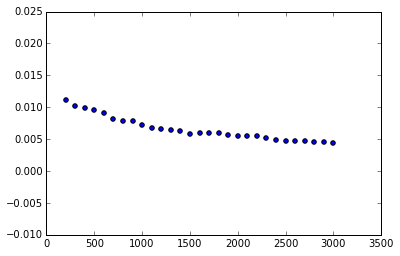

In [21]:
max = 3000

X = np.linspace(100, max, max/100)

plt.scatter(X[1:max/100], b_vals[1:max/100]) # first val is an outlier


quad coeffs: -4.46917143205e-06, 0.0616056755078, 78.9744013071
0.986737174346
lin coeffs: 0.0473043269252, 87.2870601707
0.98184693315


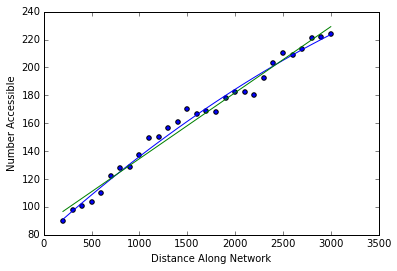

In [22]:
y = 1/(b_vals)[1:max/100]
x =  X[1:max/100]

def polyfit(x, y, degree):
    results = {}

    coeffs = np.polyfit(x, y, degree)

     # Polynomial Coefficients
    results['polynomial'] = coeffs.tolist()

    # r-squared
    p = np.poly1d(coeffs)
    # fit values, and mean
    yhat = p(x)                         # or [p(z) for z in x]
    ybar = np.sum(y)/len(y)          # or sum(y)/len(y)
    ssreg = np.sum((yhat-ybar)**2)   # or sum([ (yihat - ybar)**2 for yihat in yhat])
    sstot = np.sum((y - ybar)**2)    # or sum([ (yi - ybar)**2 for yi in y])
    results['determination'] = ssreg / sstot

    return results

quad = polyfit(x, y, 2)

a, b, c = quad['polynomial']

lin = polyfit(x, y, 1)

d, e = lin['polynomial']

f2 = a * X ** 2 + b * X + c

f1 = d * X + e

print 'quad coeffs: {}, {}, {}'.format(a, b, c)

print quad['determination']

print 'lin coeffs: {}, {}'.format(d, e)

print lin['determination']

plt.scatter(x, y)

plt.plot(X[1:max/100], f2[1:max/100])
plt.plot(X[1:max/100], f1[1:max/100])
plt.xlabel("Distance Along Network")
plt.ylabel("Number Accessible")

0.0388455739289 15.2981672144


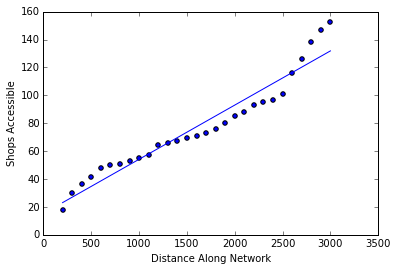

In [14]:
y = 1/(b_vals)[1:max/100]
x =  X[1:max/100]

a, b = np.polyfit(x, y, 1)

print a, b

f1 = a * X + b

plt.scatter(x, y)

plt.plot(X[1:max/100], f1[1:max/100])
plt.xlabel("Distance Along Network")
plt.ylabel("Number Accessible")

In [45]:
from shapely.geometry import Point
from fiona.crs import from_epsg
import geopandas as gpd
bbox=[-74.260380, 40.485808, -73.699296, 40.917691]
bbox = gpd.GeoSeries([Point(bbox[0], bbox[1]),
                      Point(bbox[2], bbox[3])], 
                     crs=from_epsg(4326))
bbox = bbox.to_crs(epsg=2263)
bbox = [bbox[0].x, bbox[0].y, bbox[1].x, bbox[1].y]

## Here's a map of the distance to the nearest restaurant

In [29]:
%time s = net.aggregate(3000, type="sum", decay="flat")
# %time t = net.aggregate(1000, type="sum", decay="linear")
# %time u = net.aggregate(2000, type="sum", decay="linear")
# %time v = net.aggregate(3000, type="sum", decay="linear")
# %time w = net.aggregate(3000, type="count", decay="flat")

Wall time: 34.3 s


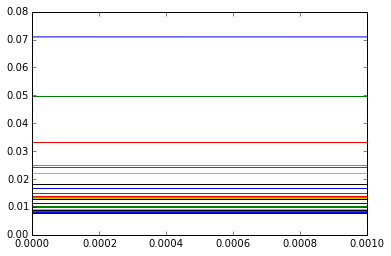

In [12]:
L = np.linspace(0, 0.001,100)

def expgraph(b, L):
    return b * np.exp(-b * L)

for i in b_vals[1:]:
    plt.plot(L, (expgraph(i, L)))
    # axes?
plt.show()

## Here's a map of access to restaurants with a 500m radius

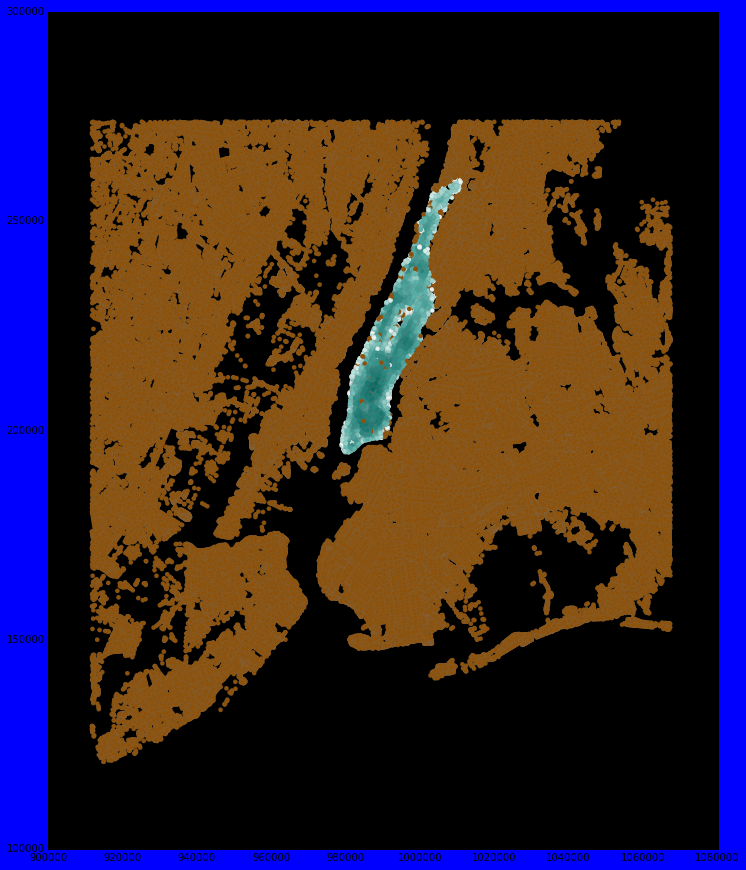

In [28]:
net.plot(s, bbox=bbox, scheme="diverging", 
         color="BrBG", log_scale=True)